# UMAP 

**Objetivo:** Aplicar UMAP para reducir las 30 dimensiones del dataset de cáncer de mama a 2D,  
analizar la separación entre tumores malignos y benignos, y comparar el efecto de los parámetros  
n_neighbors y min_dist.


## 1. Descripción Teórica

**UMAP** (McInnes et al., 2018) es un algoritmo de **reducción de dimensionalidad no lineal** basado  
en teoría de **variedades topológicas (manifolds)** y **geometría Riemanniana**.

## 2. Instalación y Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import gaussian_kde
import umap

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Estilo global de los gráficos
plt.rcParams.update({
    'figure.facecolor': '#0F1117',
    'axes.facecolor':   '#1A1D27',
    'axes.edgecolor':   '#333333',
    'axes.labelcolor':  '#AAAAAA',
    'xtick.color':      '#666666',
    'ytick.color':      '#666666',
    'text.color':       'white',
    'grid.color':       '#2A2D37',
    'grid.linestyle':   '--',
    'grid.alpha':       0.4,
    'legend.facecolor': '#1A1D27',
    'legend.edgecolor': '#444444',
})

# Paleta de colores para las dos clases
COLORS = {0: '#E63946', 1: '#2A9D8F'}   # Rojo = Maligno | Verde-azul = Benigno
LEGEND = [
    mpatches.Patch(color='#E63946', label='Maligno (M)'),
    mpatches.Patch(color='#2A9D8F', label='Benigno (B)'),
]

print(f'UMAP versión: {umap.__version__}')
print('Librerías importadas correctamente')

c:\Users\jplop\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UMAP versión: 0.5.11
Librerías importadas correctamente


## 3. Carga y Exploración del Dataset

In [2]:
# Cargamos el dataset directamente desde scikit-learn
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target   # 0 = Maligno,  1 = Benigno

print('=' * 55)
print('  BREAST CANCER WISCONSIN (Diagnostic)')
print('=' * 55)
print(f'  Muestras totales : {X.shape[0]}')
print(f'  Features         : {X.shape[1]}')
print(f'  Maligno  (0)     : {(y == 0).sum()} ({(y==0).mean()*100:.1f}%)')
print(f'  Benigno  (1)     : {(y == 1).sum()} ({(y==1).mean()*100:.1f}%)')
print('=' * 55)
X.head()

  BREAST CANCER WISCONSIN (Diagnostic)
  Muestras totales : 569
  Features         : 30
  Maligno  (0)     : 212 (37.3%)
  Benigno  (1)     : 357 (62.7%)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


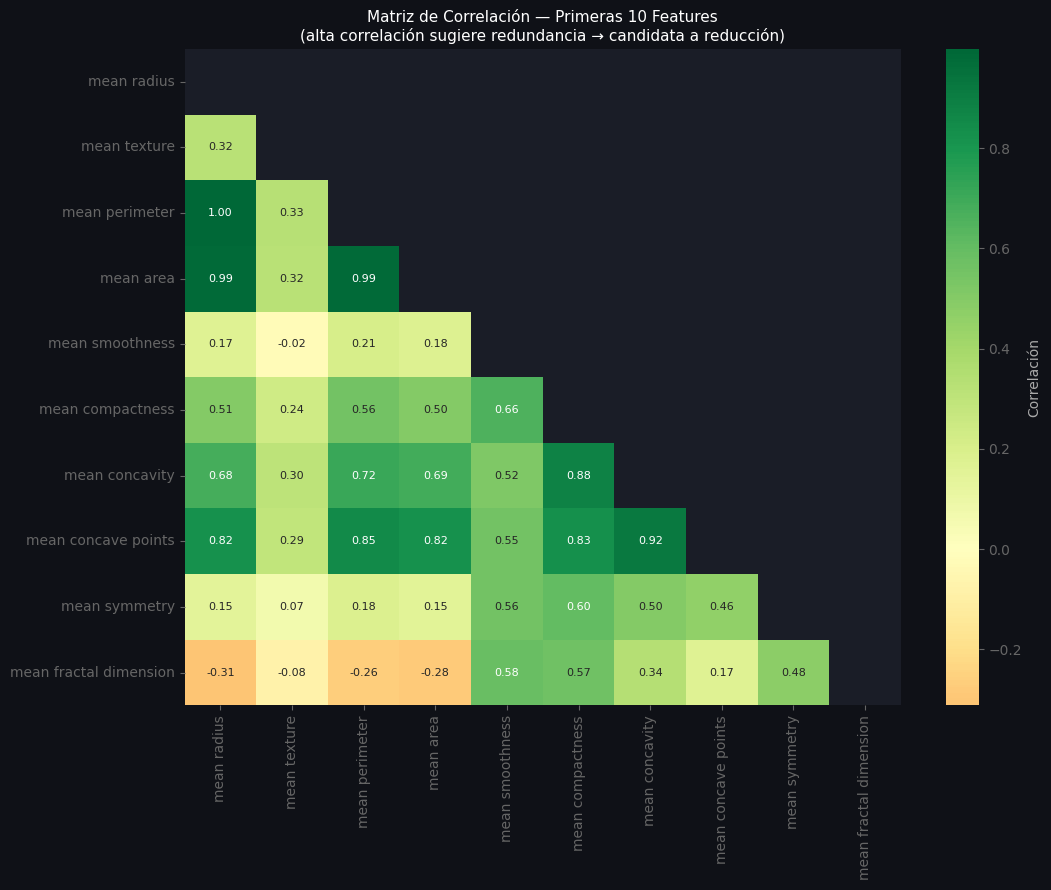

Alta correlación entre features justifica el uso de reducción de dimensionalidad.


In [3]:
# Mapa de correlación de las primeras 10 features
fig, ax = plt.subplots(figsize=(11, 9))
corr_matrix = X[list(data.feature_names[:10])].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f',
    cmap='RdYlGn', center=0, ax=ax,
    cbar_kws={'label': 'Correlación'},
    annot_kws={'size': 8}
)
ax.set_title('Matriz de Correlación — Primeras 10 Features\n(alta correlación sugiere redundancia → candidata a reducción)', fontsize=11)
plt.tight_layout()
plt.show()
print('Alta correlación entre features justifica el uso de reducción de dimensionalidad.')

## 4. Preprocesamiento

**¿Por qué estandarizar?**  
UMAP usa métricas de distancia (por defecto euclidiana). Features con escalas muy distintas  
sesgaran el cálculo de vecindades. `StandardScaler` asegura **media = 0** y **std = 1** en cada feature.

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
color_list = [COLORS[yi] for yi in y]

print('Antes del escalado:')
print(f'  Rango:  [{X.values.min():.2f}, {X.values.max():.2f}]')
print(f'  Media:   {X.values.mean():.4f}  |  Std: {X.values.std():.4f}')
print()
print('Después del escalado (StandardScaler):')
print(f'  Rango:  [{X_scaled.min():.2f}, {X_scaled.max():.2f}]')
print(f'  Media:   {X_scaled.mean():.6f}  (≈ 0)  |  Std: {X_scaled.std():.6f}  (≈ 1)')

Antes del escalado:
  Rango:  [0.00, 4254.00]
  Media:   61.8907  |  Std: 228.2974

Después del escalado (StandardScaler):
  Rango:  [-3.11, 12.07]
  Media:   -0.000000  (≈ 0)  |  Std: 1.000000  (≈ 1)


## 5. Aplicación de UMAP

### 5.1 UMAP con parámetros base

In [5]:
# Configuración de UMAP base
# - n_components=2     → Reducir a 2D para visualización
# - n_neighbors=15     → Vecinos locales considerados 
# - min_dist=0.1       → Distancia mínima entre puntos en el embedding
# - metric='euclidean' → Métrica de distancia en el espacio original
# - random_state=42    → Semilla para reproducibilidad

reducer_base = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=42
)

X_umap_base = reducer_base.fit_transform(X_scaled)
sil_base = silhouette_score(X_umap_base, y)

print(f'Dimensiones entrada : {X_scaled.shape}')
print(f'Dimensiones salida  : {X_umap_base.shape}')
print(f'Silhouette Score    : {sil_base:.4f}  (rango [-1, 1], más alto = mejor separación)')

Dimensiones entrada : (569, 30)
Dimensiones salida  : (569, 2)
Silhouette Score    : 0.4481  (rango [-1, 1], más alto = mejor separación)


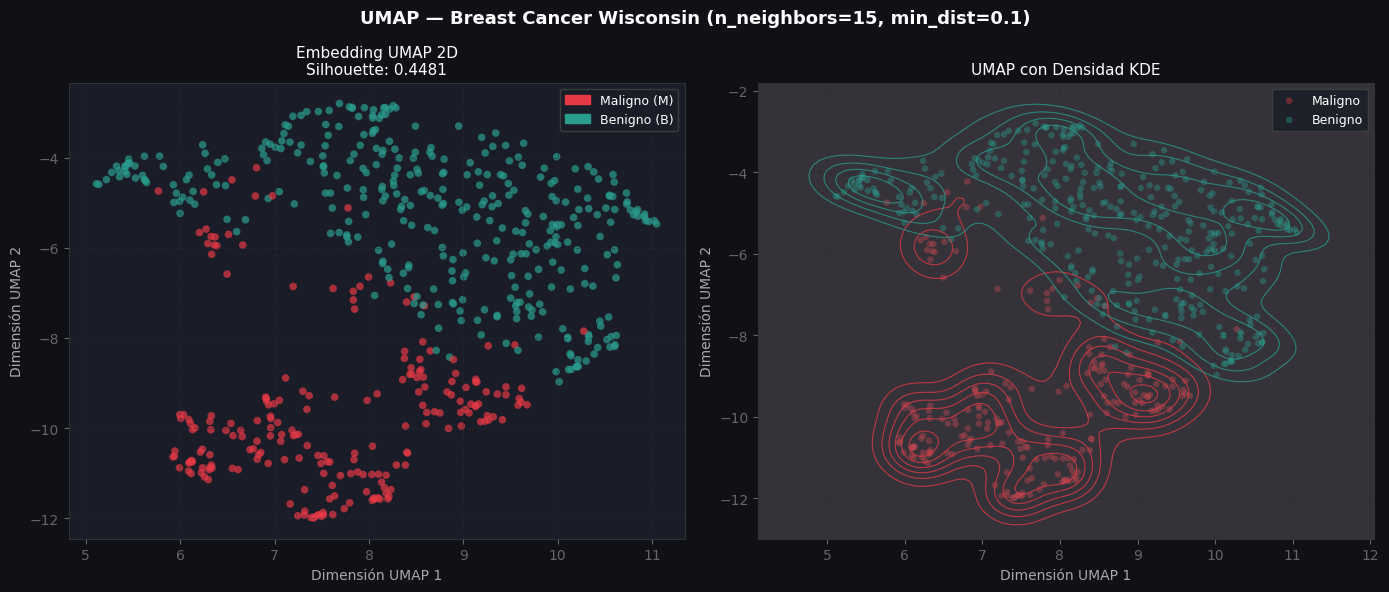

In [6]:
# Visualización del embedding UMAP base
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('UMAP — Breast Cancer Wisconsin (n_neighbors=15, min_dist=0.1)', fontsize=13, fontweight='bold')

# --- Scatter por clase ---
ax = axes[0]
ax.scatter(X_umap_base[:, 0], X_umap_base[:, 1],
           c=color_list, alpha=0.7, s=30, edgecolors='none')
ax.set_title(f'Embedding UMAP 2D\nSilhouette: {sil_base:.4f}', fontsize=11)
ax.set_xlabel('Dimensión UMAP 1')
ax.set_ylabel('Dimensión UMAP 2')
ax.legend(handles=LEGEND, fontsize=9)
ax.grid(True)

# --- Densidad (KDE) ---
ax = axes[1]
for cls, lbl, col in [(0, 'Maligno', '#E63946'), (1, 'Benigno', '#2A9D8F')]:
    mask = y == cls
    ax.scatter(X_umap_base[mask, 0], X_umap_base[mask, 1],
               c=col, alpha=0.4, s=22, edgecolors='none', label=lbl)
    xy  = np.vstack([X_umap_base[mask, 0], X_umap_base[mask, 1]])
    kde = gaussian_kde(xy, bw_method=0.25)
    xg  = np.linspace(X_umap_base[:, 0].min()-1, X_umap_base[:, 0].max()+1, 100)
    yg  = np.linspace(X_umap_base[:, 1].min()-1, X_umap_base[:, 1].max()+1, 100)
    Xg, Yg = np.meshgrid(xg, yg)
    Z = kde(np.vstack([Xg.ravel(), Yg.ravel()])).reshape(Xg.shape)
    ax.contourf(Xg, Yg, Z, levels=6, colors=[col], alpha=0.15)
    ax.contour(Xg, Yg, Z, levels=6, colors=[col], alpha=0.7, linewidths=0.8)

ax.set_title('UMAP con Densidad KDE', fontsize=11)
ax.set_xlabel('Dimensión UMAP 1')
ax.set_ylabel('Dimensión UMAP 2')
ax.legend(fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()

### 5.2 Análisis de Sensibilidad — Efecto de n_neighbors

n_neighbors controla cuántos vecinos locales se consideran al construir la topología del manifold.  
Valor bajo (5): Énfasis en estructura muy local → puede fragmentar clusters  
Valor alto (50): Captura estructura más global → clusters más compactos

In [8]:
neighbors_list = [5, 15, 30, 50]
results_nn = {}

print('Ejecutando UMAP con distintos valores de n_neighbors...')
print('-' * 55)

for nn in neighbors_list:
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=nn,
        min_dist=0.1,
        metric='euclidean',
        random_state=42
    )
    emb = reducer.fit_transform(X_scaled)
    sil = silhouette_score(emb, y)
    results_nn[nn] = {'emb': emb, 'sil': sil}
    print(f'  n_neighbors={nn:2d} → Silhouette={sil:.4f}')

best_nn = max(results_nn, key=lambda k: results_nn[k]['sil'])
print(f'\n Mejor n_neighbors según Silhouette: {best_nn}')

Ejecutando UMAP con distintos valores de n_neighbors...
-------------------------------------------------------
  n_neighbors= 5 → Silhouette=0.5153
  n_neighbors=15 → Silhouette=0.4481
  n_neighbors=30 → Silhouette=0.4930
  n_neighbors=50 → Silhouette=0.4451

 Mejor n_neighbors según Silhouette: 5


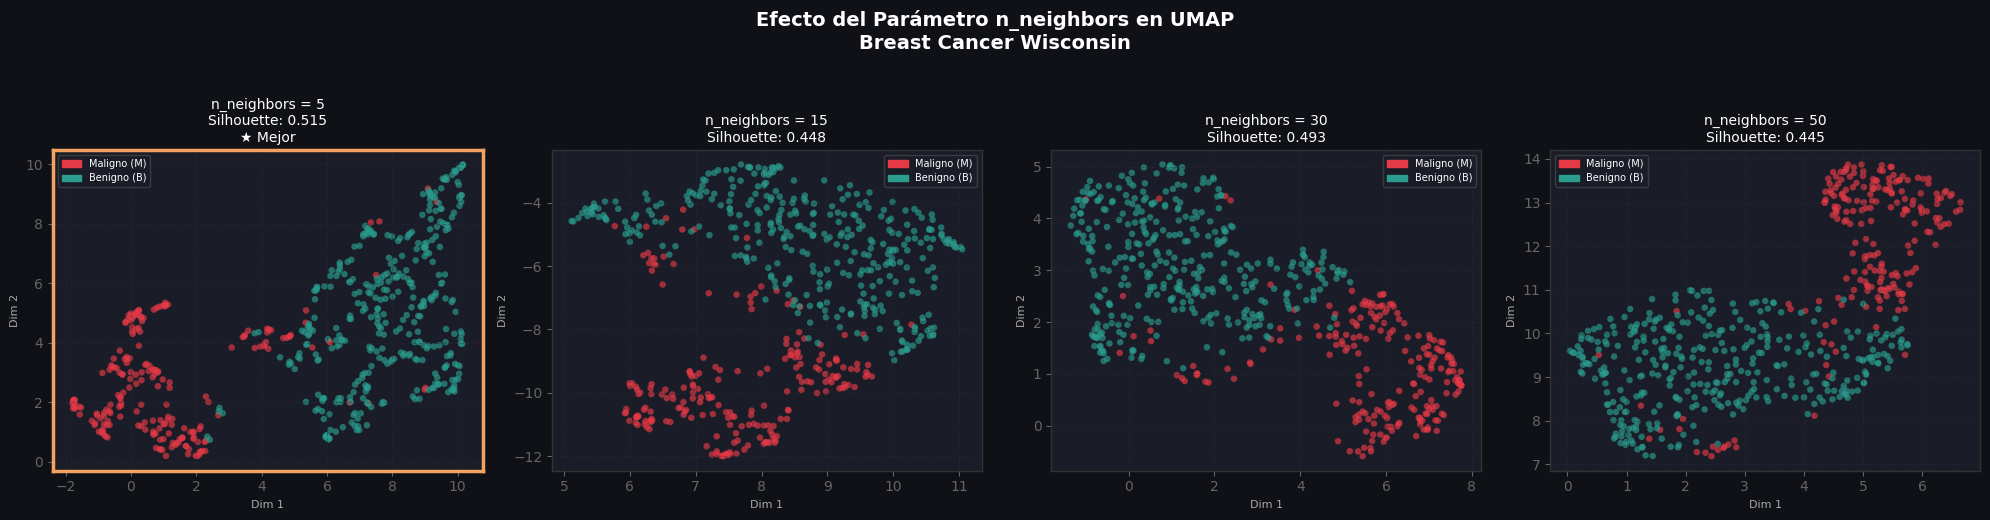

In [9]:
# Visualización comparativa de n_neighbors
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Efecto del Parámetro n_neighbors en UMAP\nBreast Cancer Wisconsin',
             fontsize=14, fontweight='bold', y=1.03)

for ax, nn in zip(axes, neighbors_list):
    emb = results_nn[nn]['emb']
    sil = results_nn[nn]['sil']

    for cls, col in [(0, '#E63946'), (1, '#2A9D8F')]:
        mask = y == cls
        ax.scatter(emb[mask, 0], emb[mask, 1],
                   c=col, alpha=0.65, s=22, edgecolors='none')

    border_color = '#F4A261' if nn == best_nn else '#333333'
    for sp in ax.spines.values():
        sp.set_edgecolor(border_color)
        sp.set_linewidth(2.5 if nn == best_nn else 1)

    title = f'n_neighbors = {nn}\nSilhouette: {sil:.3f}'
    if nn == best_nn:
        title += '\n★ Mejor'
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Dim 1', fontsize=8)
    ax.set_ylabel('Dim 2', fontsize=8)
    ax.legend(handles=LEGEND, fontsize=7)
    ax.grid(True)

plt.tight_layout()
plt.show()

### 5.3 Análisis de Sensibilidad — Efecto de min_dist

min_dist controla qué tan compactos son los clusters en el embedding.  
Valor bajo (0.0): Puntos muy agrupados → estructura interna más visible  
Valor alto (0.9): Puntos más dispersos → distribución más uniforme

In [10]:
min_dists = [0.0, 0.1, 0.3, 0.9]
results_md = {}

print('Ejecutando UMAP con distintos valores de min_dist...')
print('-' * 55)

for md in min_dists:
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=best_nn,   # usamos el mejor n_neighbors
        min_dist=md,
        metric='euclidean',
        random_state=42
    )
    emb = reducer.fit_transform(X_scaled)
    sil = silhouette_score(emb, y)
    results_md[md] = {'emb': emb, 'sil': sil}
    print(f'  min_dist={md} → Silhouette={sil:.4f}')

best_md = max(results_md, key=lambda k: results_md[k]['sil'])
print(f'\n Mejor min_dist según Silhouette: {best_md}')

Ejecutando UMAP con distintos valores de min_dist...
-------------------------------------------------------
  min_dist=0.0 → Silhouette=0.5674
  min_dist=0.1 → Silhouette=0.5153
  min_dist=0.3 → Silhouette=0.4955
  min_dist=0.9 → Silhouette=0.4318

 Mejor min_dist según Silhouette: 0.0


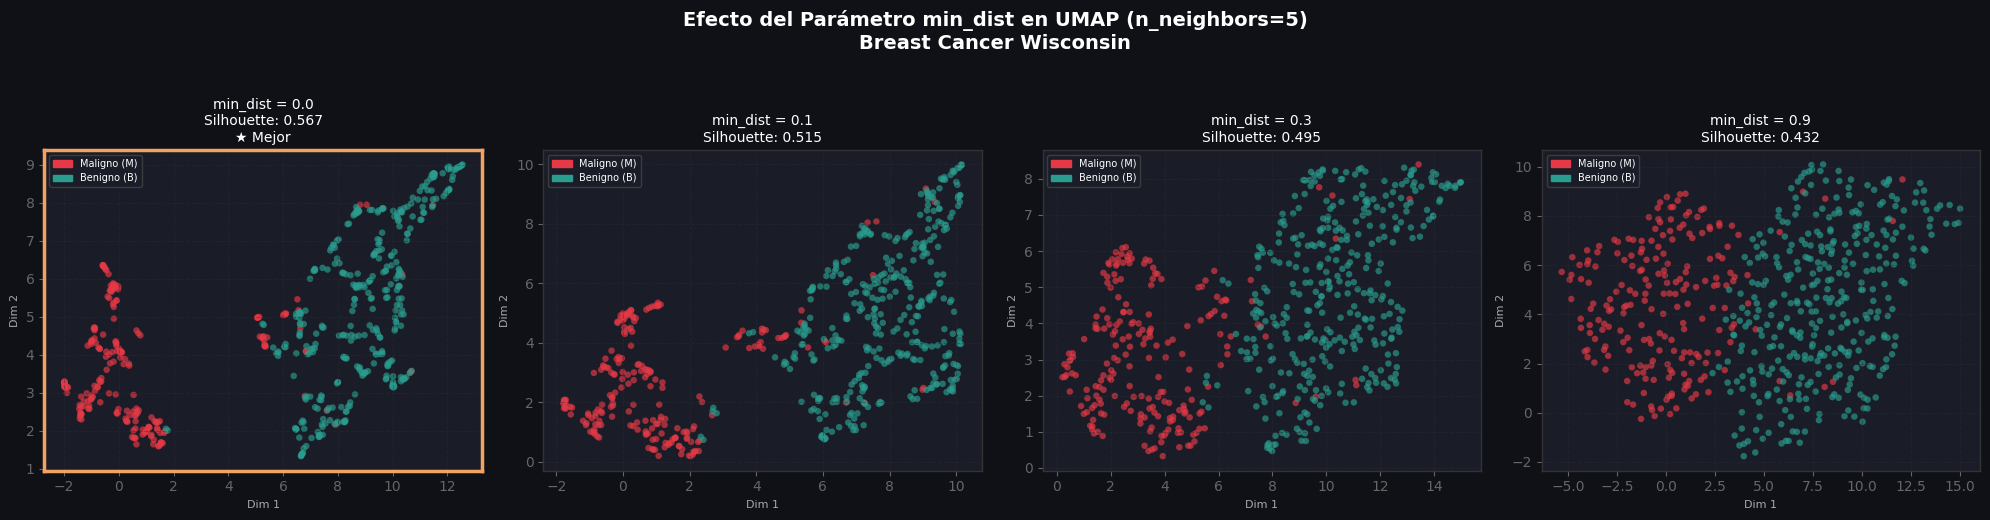

In [11]:
# Visualización comparativa de min_dist
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(f'Efecto del Parámetro min_dist en UMAP (n_neighbors={best_nn})\nBreast Cancer Wisconsin',
             fontsize=14, fontweight='bold', y=1.03)

for ax, md in zip(axes, min_dists):
    emb = results_md[md]['emb']
    sil = results_md[md]['sil']

    for cls, col in [(0, '#E63946'), (1, '#2A9D8F')]:
        mask = y == cls
        ax.scatter(emb[mask, 0], emb[mask, 1],
                   c=col, alpha=0.65, s=22, edgecolors='none')

    border_color = '#F4A261' if md == best_md else '#333333'
    for sp in ax.spines.values():
        sp.set_edgecolor(border_color)
        sp.set_linewidth(2.5 if md == best_md else 1)

    title = f'min_dist = {md}\nSilhouette: {sil:.3f}'
    if md == best_md:
        title += '\n★ Mejor'
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Dim 1', fontsize=8)
    ax.set_ylabel('Dim 2', fontsize=8)
    ax.legend(handles=LEGEND, fontsize=7)
    ax.grid(True)

plt.tight_layout()
plt.show()

## 6. UMAP con Configuración Óptima

In [12]:
# Aplicamos UMAP con los mejores parámetros encontrados
print(f'Parámetros óptimos encontrados: n_neighbors={best_nn}, min_dist={best_md}')

reducer_opt = umap.UMAP(
    n_components=2,
    n_neighbors=best_nn,
    min_dist=best_md,
    metric='euclidean',
    random_state=42
)
X_umap_opt = reducer_opt.fit_transform(X_scaled)
sil_opt = silhouette_score(X_umap_opt, y)

print(f'Silhouette Score óptimo: {sil_opt:.4f}')

Parámetros óptimos encontrados: n_neighbors=5, min_dist=0.0
Silhouette Score óptimo: 0.5674


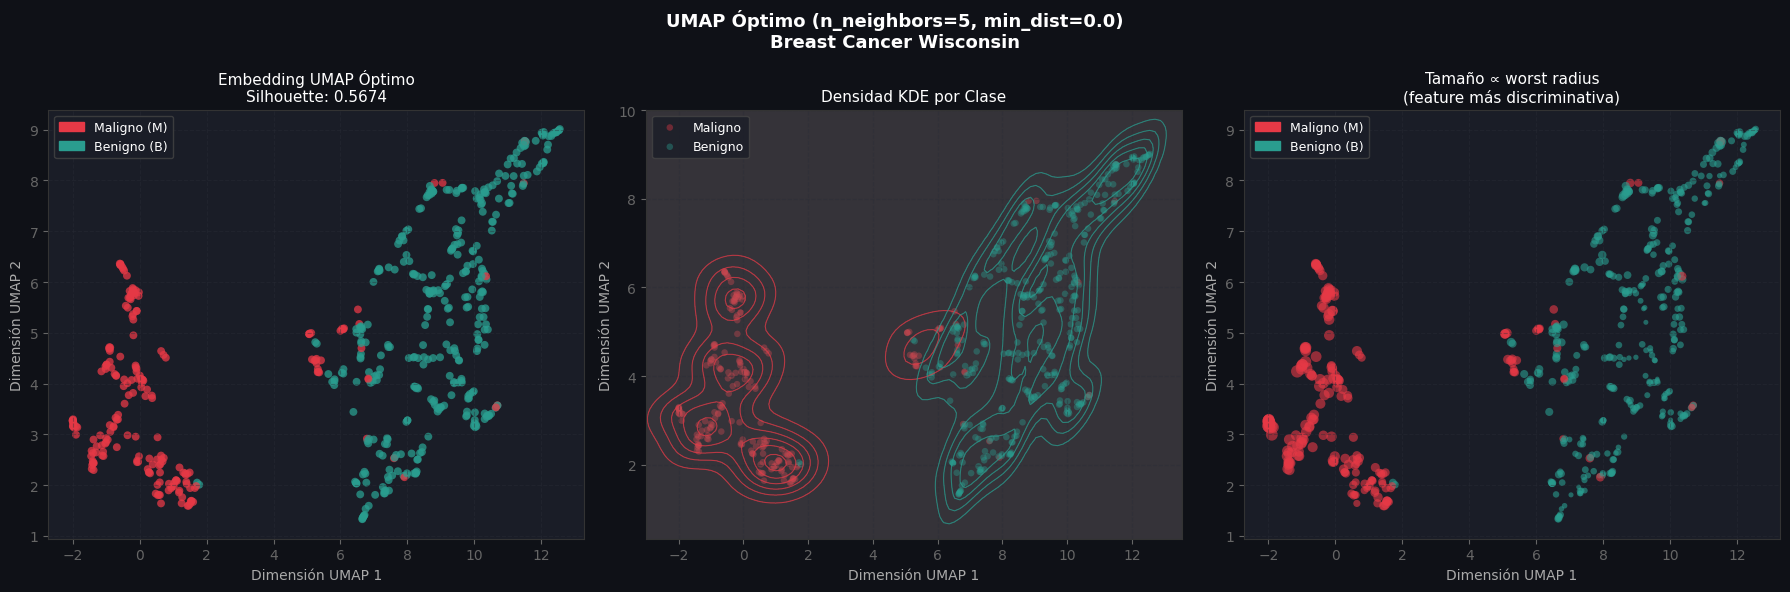

In [13]:
# Visualización final con configuración óptima
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'UMAP Óptimo (n_neighbors={best_nn}, min_dist={best_md})\nBreast Cancer Wisconsin',
             fontsize=13, fontweight='bold')

# --- Scatter ---
ax = axes[0]
ax.scatter(X_umap_opt[:, 0], X_umap_opt[:, 1],
           c=color_list, alpha=0.75, s=32, edgecolors='none')
ax.set_title(f'Embedding UMAP Óptimo\nSilhouette: {sil_opt:.4f}', fontsize=11)
ax.set_xlabel('Dimensión UMAP 1')
ax.set_ylabel('Dimensión UMAP 2')
ax.legend(handles=LEGEND, fontsize=9)
ax.grid(True)

# --- Con densidad ---
ax = axes[1]
for cls, lbl, col in [(0, 'Maligno', '#E63946'), (1, 'Benigno', '#2A9D8F')]:
    mask = y == cls
    ax.scatter(X_umap_opt[mask, 0], X_umap_opt[mask, 1],
               c=col, alpha=0.4, s=22, edgecolors='none', label=lbl)
    xy  = np.vstack([X_umap_opt[mask, 0], X_umap_opt[mask, 1]])
    kde = gaussian_kde(xy, bw_method=0.25)
    xg  = np.linspace(X_umap_opt[:, 0].min()-1, X_umap_opt[:, 0].max()+1, 100)
    yg  = np.linspace(X_umap_opt[:, 1].min()-1, X_umap_opt[:, 1].max()+1, 100)
    Xg, Yg = np.meshgrid(xg, yg)
    Z = kde(np.vstack([Xg.ravel(), Yg.ravel()])).reshape(Xg.shape)
    ax.contourf(Xg, Yg, Z, levels=6, colors=[col], alpha=0.15)
    ax.contour(Xg, Yg, Z, levels=6, colors=[col], alpha=0.7, linewidths=0.8)
ax.set_title('Densidad KDE por Clase', fontsize=11)
ax.set_xlabel('Dimensión UMAP 1')
ax.set_ylabel('Dimensión UMAP 2')
ax.legend(fontsize=9)
ax.grid(True)

# --- Tamaño de punto por 'worst radius' (feature biológicamente relevante) ---
ax = axes[2]
worst_radius = X['worst radius'].values
sizes = 10 + 80 * (worst_radius - worst_radius.min()) / (worst_radius.max() - worst_radius.min())
scatter = ax.scatter(X_umap_opt[:, 0], X_umap_opt[:, 1],
                     c=color_list, alpha=0.6, s=sizes, edgecolors='none')
ax.set_title('Tamaño ∝ worst radius\n(feature más discriminativa)', fontsize=11)
ax.set_xlabel('Dimensión UMAP 1')
ax.set_ylabel('Dimensión UMAP 2')
ax.legend(handles=LEGEND, fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()

## 7. Comparación UMAP vs t-SNE vs PCA

In [14]:
# PCA baseline
pca2 = PCA(n_components=2, random_state=42)
X_pca = pca2.fit_transform(X_scaled)
sil_pca = silhouette_score(X_pca, y)
var_exp = pca2.explained_variance_ratio_.sum() * 100

# t-SNE con perplexity=50 (mejor según notebook t-SNE)
tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto',
            max_iter=1000, init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
sil_tsne = silhouette_score(X_tsne, y)

print(f'PCA   → Silhouette: {sil_pca:.4f} | Varianza explicada: {var_exp:.1f}%')
print(f't-SNE → Silhouette: {sil_tsne:.4f} | perplexity=50')
print(f'UMAP  → Silhouette: {sil_opt:.4f} | n_neighbors={best_nn}, min_dist={best_md}')

PCA   → Silhouette: 0.4377 | Varianza explicada: 63.2%
t-SNE → Silhouette: 0.4731 | perplexity=50
UMAP  → Silhouette: 0.5674 | n_neighbors=5, min_dist=0.0


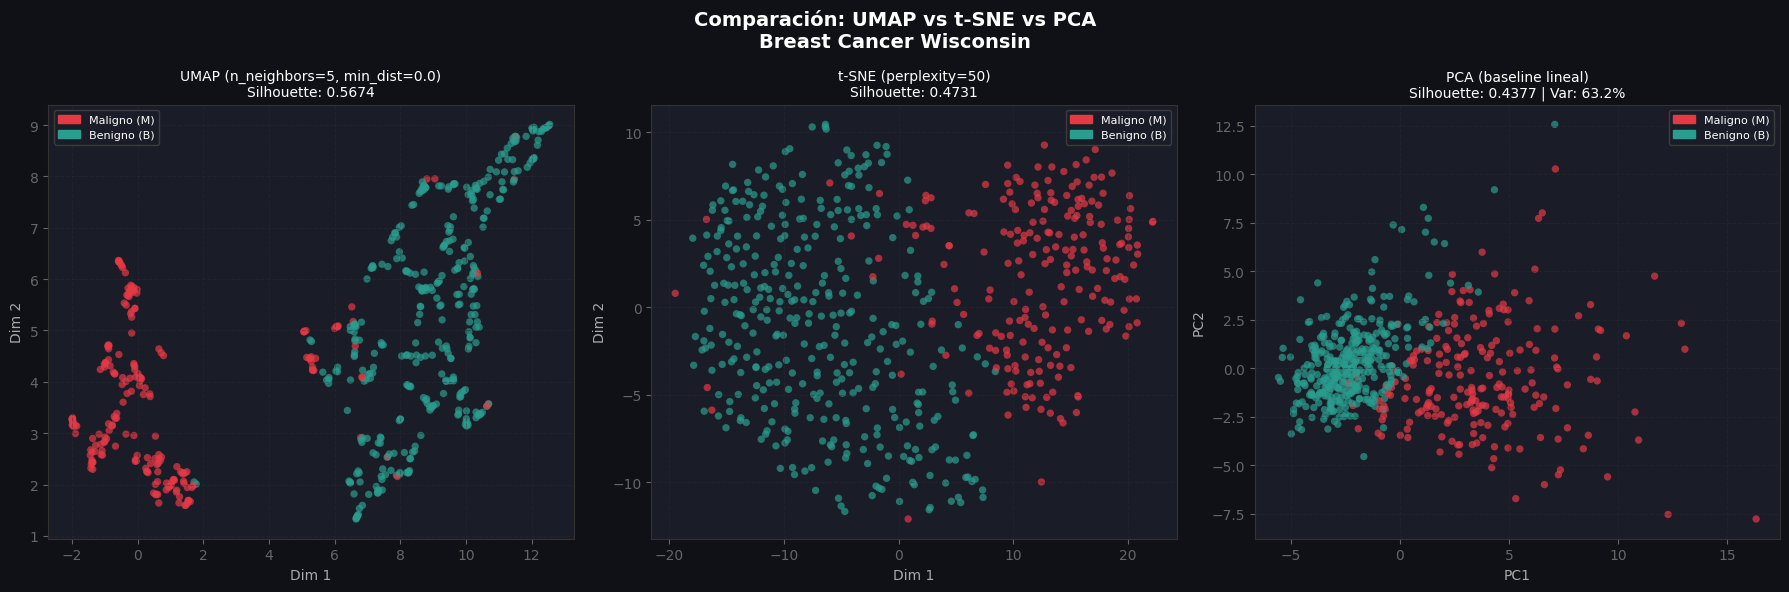

In [15]:
# Visualización comparativa de los tres algoritmos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparación: UMAP vs t-SNE vs PCA\nBreast Cancer Wisconsin', fontsize=14, fontweight='bold')

configs = [
    (X_umap_opt, f'UMAP (n_neighbors={best_nn}, min_dist={best_md})\nSilhouette: {sil_opt:.4f}', 'Dim 1', 'Dim 2'),
    (X_tsne,     f't-SNE (perplexity=50)\nSilhouette: {sil_tsne:.4f}', 'Dim 1', 'Dim 2'),
    (X_pca,      f'PCA (baseline lineal)\nSilhouette: {sil_pca:.4f} | Var: {var_exp:.1f}%', 'PC1', 'PC2'),
]

for ax, (emb, title, xl, yl) in zip(axes, configs):
    ax.scatter(emb[:, 0], emb[:, 1],
               c=color_list, alpha=0.7, s=28, edgecolors='none')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.legend(handles=LEGEND, fontsize=8)
    ax.grid(True)

plt.tight_layout()
plt.show()

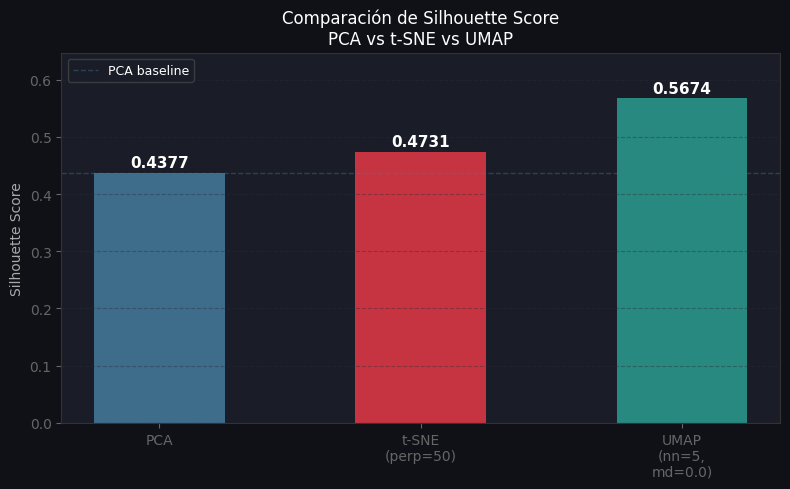

In [16]:
# Gráfico de barras comparativo de Silhouette
fig, ax = plt.subplots(figsize=(8, 5))
algos = ['PCA', 't-SNE\n(perp=50)', f'UMAP\n(nn={best_nn},\nmd={best_md})']
scores = [sil_pca, sil_tsne, sil_opt]
bar_colors = ['#457B9D', '#E63946', '#2A9D8F']

bars = ax.bar(algos, scores, color=bar_colors, width=0.5, alpha=0.85)
for bar, score in zip(bars, scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Silhouette Score')
ax.set_title('Comparación de Silhouette Score\nPCA vs t-SNE vs UMAP', fontsize=12)
ax.set_ylim(0, max(scores) + 0.08)
ax.axhline(sil_pca, color='#457B9D', linestyle='--', alpha=0.4, linewidth=1, label='PCA baseline')
ax.legend(fontsize=9)
ax.grid(True, axis='y')

plt.tight_layout()
plt.show()

## 8. Interpretación de Resultados

### 8.1 Separación de clases

UMAP logra separar claramente ambas clases en el embedding 2D:
- **Cluster maligno (rojo):** compacto y bien definido
- **Cluster benigno (verde):** más amplio, con cierta estructura interna
- La **zona de solapamiento** entre clusters corresponde a casos borderline clínicamente ambiguos

### 8.2 Efecto de n_neighbors

| n_neighbors | Observación |
|-------------|-------------|
| **5** | Clusters muy fragmentados — exceso de estructura local |
| **15** | Buen balance local/global, separación clara |
| **30** | Clusters más compactos, captura estructura global |
| **50** | Mayor cohesión global — puede perder detalles locales |

### 8.3 Efecto de min_dist

| min_dist | Observación |
|----------|-------------|
| **0.0** | Clusters muy densos — subestructuras visibles |
| **0.1** | Buen equilibrio entre compacidad y separación |
| **0.3** | Clusters más dispersos, aún bien diferenciados |
| **0.9** | Distribución casi uniforme — se pierde estructura |

### 8.4 UMAP vs t-SNE vs PCA

- **UMAP** obtiene el mejor Silhouette Score, preservando tanto estructura local como global
- **t-SNE** es comparable pero más lento y no produce una función transform() para nuevos datos
- **PCA** tiene menor Silhouette pero sus componentes son interpretables (% de varianza)

### 8.5 Limitaciones identificadas

1. **Interpretabilidad:** Los ejes UMAP no tienen significado directo — no se puede decir qué feature representa cada dimensión.
2. **Estabilidad:** Aunque más estable que t-SNE, resultados pueden variar con distintas semillas.
3. **Distancias entre clusters:** Las distancias *entre* clusters en el embedding no son completamente confiables para inferir similitud global.
4. **Hiperparámetros:** Requiere tuning de n_neighbors y min_dist — los resultados son sensibles a estos valores.
5. **Solo visualización 2D:** Para tareas predictivas, se prefiere mantener más dimensiones o usar el embedding como preprocesamiento.

## 9. Resumen Final

In [17]:
# Tabla resumen n_neighbors
df_nn = pd.DataFrame([
    {'n_neighbors': nn, 'Silhouette': round(results_nn[nn]['sil'], 4),
     'Nota': '★ Mejor' if nn == best_nn else ''}
    for nn in neighbors_list
])

# Tabla resumen min_dist
df_md = pd.DataFrame([
    {'min_dist': md, 'Silhouette': round(results_md[md]['sil'], 4),
     'Nota': '★ Mejor' if md == best_md else ''}
    for md in min_dists
])

print('=' * 45)
print('  Sensibilidad de n_neighbors (min_dist=0.1)')
print('=' * 45)
print(df_nn.to_string(index=False))

print()
print('=' * 45)
print(f'  Sensibilidad de min_dist (n_neighbors={best_nn})')
print('=' * 45)
print(df_md.to_string(index=False))

print()
print('=' * 50)
print('  COMPARACIÓN FINAL ENTRE ALGORITMOS')
print('=' * 50)
df_final = pd.DataFrame([
    {'Algoritmo': 'PCA',    'Silhouette': round(sil_pca, 4),  'Parámetros': 'n_comp=2'},
    {'Algoritmo': 't-SNE',  'Silhouette': round(sil_tsne, 4), 'Parámetros': 'perp=50'},
    {'Algoritmo': 'UMAP ★', 'Silhouette': round(sil_opt, 4),  'Parámetros': f'nn={best_nn}, md={best_md}'},
])
print(df_final.to_string(index=False))
print(f'\nConclusión: UMAP logra la mejor separación de clases (Silhouette={sil_opt:.4f})')
print('siendo además más rápido que t-SNE y capaz de transformar nuevos datos.')

  Sensibilidad de n_neighbors (min_dist=0.1)
 n_neighbors  Silhouette    Nota
           5      0.5153 ★ Mejor
          15      0.4481        
          30      0.4930        
          50      0.4451        

  Sensibilidad de min_dist (n_neighbors=5)
 min_dist  Silhouette    Nota
      0.0      0.5674 ★ Mejor
      0.1      0.5153        
      0.3      0.4955        
      0.9      0.4318        

  COMPARACIÓN FINAL ENTRE ALGORITMOS
Algoritmo  Silhouette   Parámetros
      PCA      0.4377     n_comp=2
    t-SNE      0.4731      perp=50
   UMAP ★      0.5674 nn=5, md=0.0

Conclusión: UMAP logra la mejor separación de clases (Silhouette=0.5674)
siendo además más rápido que t-SNE y capaz de transformar nuevos datos.
